# VGG

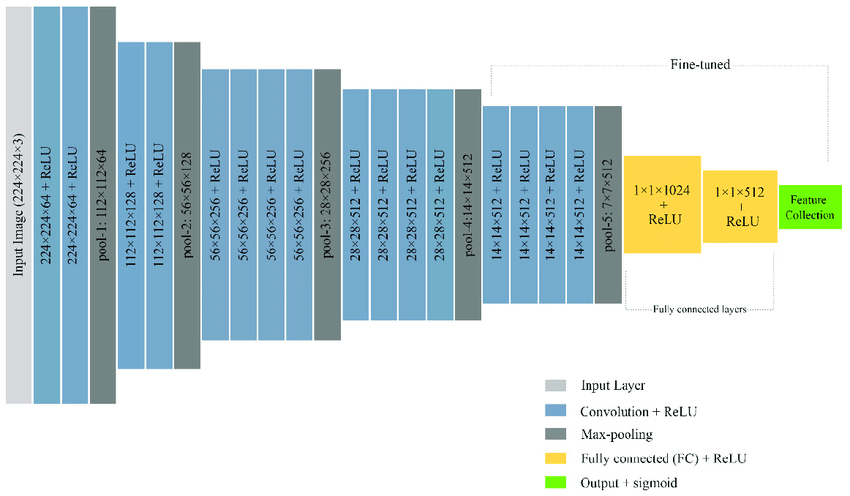

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F


In [ ]:
VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        "M",
        512,
        512,
        "M",
        512,
        512,
        "M",
    ],
    "VGG16": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
    "VGG19": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ],
}



In [ ]:
class VGG(nn.Module):
    def __init__(
        self,
        architecture,
        in_channels=3,
        in_height=224,
        in_width=224,
        num_hidden=4096,
        num_classes=1000
    ):
        super(VGG, self).__init__()
        self.in_channels = in_channels
        self.in_width = in_width
        self.in_height = in_height
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.convs = self.init_convs(architecture)
        self.fcs = self.init_fcs(architecture)

    def forward(self, x):
        x = self.convs(x)
        x = x.reshape(x.size(0), -1)
        x = self.fcs(x)
        return x

    def init_fcs(self, architecture):
        pool_count = architecture.count("M")
        factor = (2 ** pool_count)
        if (self.in_height % factor) + (self.in_width % factor) != 0:
            raise ValueError(
                f"`in_height` and `in_width` must be multiples of {factor}"
            )
        out_height = self.in_height // factor
        out_width = self.in_width // factor
        last_out_channels = next(
            x for x in architecture[::-1] if type(x) == int
        )
        return nn.Sequential(
            nn.Linear(
                last_out_channels * out_height * out_width,
                self.num_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(self.num_hidden, self.num_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(self.num_hidden, self.num_classes)
        )

    def init_convs(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers.extend(
                    [
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding=(1, 1),
                        ),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(),
                    ]
                )
                in_channels = x
            else:
                layers.append(
                    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
                )

        return nn.Sequential(*layers)



In [ ]:
BadVGG = VGG(
    in_channels=3,
    in_height=224,
    in_width=224,
    architecture=VGG_types["VGG16"]
)


In [ ]:
standard_input = torch.randn((2, 3, 224, 224))